In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import numpy as np

In [2]:

olivetti_faces = fetch_olivetti_faces(shuffle=True, random_state=60)
X = olivetti_faces.data
y = olivetti_faces.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, stratify=y, random_state=60)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=60)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [3]:
n_clusters_range = range(2, 21)
silhouette_scores = []

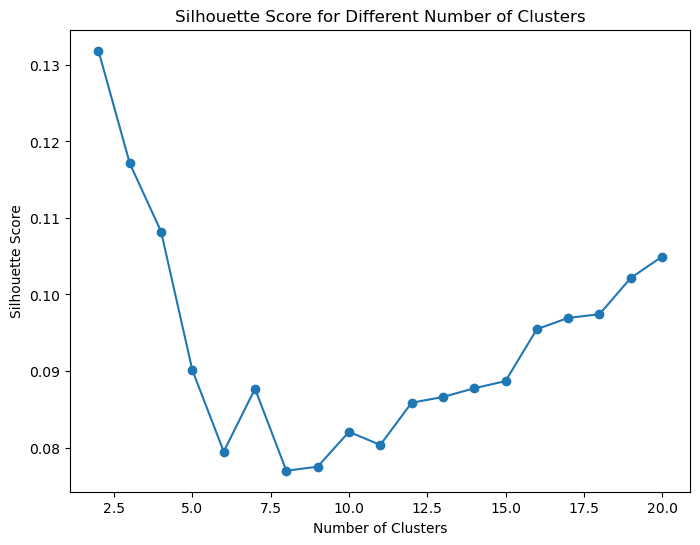

In [4]:

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=60)
    kmeans.fit(X_train)
    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [5]:
optimal_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

kmeans = KMeans(n_clusters=optimal_clusters, random_state=60)
kmeans.fit(X_train)

y_pred = kmeans.predict(X_val)

Optimal number of clusters: 2


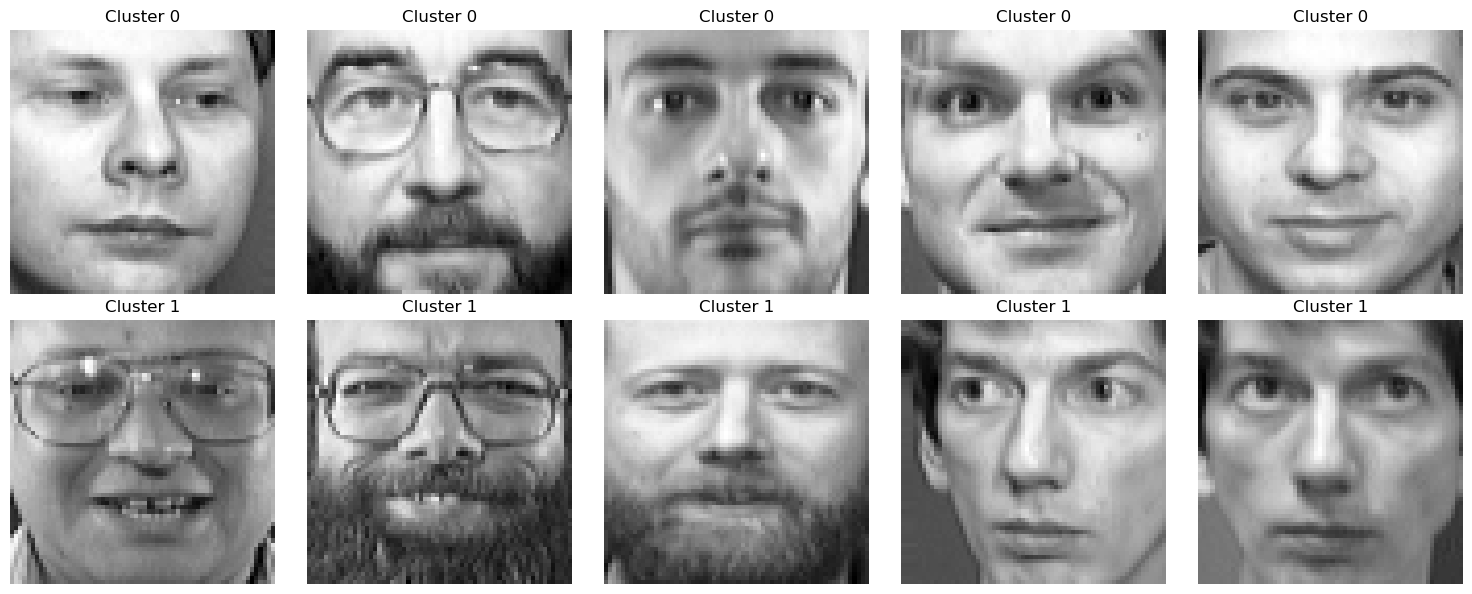

In [6]:
fig, axes = plt.subplots(optimal_clusters, 5, figsize=(15, 3 * optimal_clusters))

for cluster_id in range(optimal_clusters):
    
    cluster_images = X_train[kmeans.labels_ == cluster_id][:5]
    
    for i, img in enumerate(cluster_images):
        ax = axes[cluster_id, i]
        ax.imshow(img.reshape(64, 64), cmap='gray')
        ax.set_title(f"Cluster {cluster_id}")
        ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
model = RandomForestClassifier(n_estimators=200, random_state=60)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on the validation set (original features): {accuracy:.4f}")

Accuracy on the validation set (original features): 0.8917


In [9]:
best_accuracy = 0
best_k = 0
for k in range(2, 21):  
    kmeans = KMeans(n_clusters=k, random_state=60)
    X_train_kmeans = kmeans.fit_transform(X_train_scaled)
    X_val_kmeans = kmeans.transform(X_val_scaled)
    
    model.fit(X_train_kmeans, y_train)
    y_pred_kmeans = model.predict(X_val_kmeans)
    accuracy_kmeans = accuracy_score(y_val, y_pred_kmeans)
    
    if accuracy_kmeans > best_accuracy:
        best_accuracy = accuracy_kmeans
        best_k = k

print(f"Best K value for dimensionality reduction: {best_k}")
print(f"Best validation accuracy with KMeans reduction: {best_accuracy:.4f}")

Best K value for dimensionality reduction: 11
Best validation accuracy with KMeans reduction: 0.6500


In [10]:
best_accuracy_appended = 0
best_k_appended = 0
for k in range(2, 21): 
    kmeans = KMeans(n_clusters=k, random_state=60)
    X_train_kmeans = kmeans.fit_transform(X_train_scaled)
    X_val_kmeans = kmeans.transform(X_val_scaled)
    
    
    X_train_combined = np.hstack((X_train_scaled, X_train_kmeans))
    X_val_combined = np.hstack((X_val_scaled, X_val_kmeans))
    
    model.fit(X_train_combined, y_train)
    y_pred_combined = model.predict(X_val_combined)
    accuracy_combined = accuracy_score(y_val, y_pred_combined)
    
    if accuracy_combined > best_accuracy_appended:
        best_accuracy_appended = accuracy_combined
        best_k_appended = k

print(f"Best K value for appended features: {best_k_appended}")
print(f"Best validation accuracy with appended KMeans features: {best_accuracy_appended:.4f}")

Best K value for appended features: 7
Best validation accuracy with appended KMeans features: 0.9250


In [11]:
kmeans = KMeans(n_clusters=best_k, random_state=60)
X_train_best_kmeans = kmeans.fit_transform(X_train_scaled)

X_val_best_kmeans = kmeans.transform(X_val_scaled)
X_test_best_kmeans = kmeans.transform(X_test_scaled)

model.fit(X_train_best_kmeans, y_train)
y_pred_test = model.predict(X_test_best_kmeans)
test_accuracy_kmeans = accuracy_score(y_test, y_pred_test)

X_train_combined = np.hstack((X_train_scaled, X_train_best_kmeans))
X_val_combined = np.hstack((X_val_scaled, X_val_best_kmeans))
X_test_combined = np.hstack((X_test_scaled, X_test_best_kmeans))

model.fit(X_train_combined, y_train)
y_pred_combined = model.predict(X_test_combined)
test_accuracy_combined = accuracy_score(y_test, y_pred_combined)

print(f"Test accuracy with KMeans dimensionality reduction: {test_accuracy_kmeans:.4f}")
print(f"Test accuracy with appended KMeans features: {test_accuracy_combined:.4f}")

Test accuracy with KMeans dimensionality reduction: 0.5875
Test accuracy with appended KMeans features: 0.8875
